# Notebook to code up 3D CNN for protein-ligand scoring

### Install dependencies
- libmolgrid
- pytorch

In [1]:
!pip install molgrid

In [2]:
!pip install torch torchvision

### Imports

In [0]:
import molgrid

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

import matplotlib.pyplot as plt
%matplotlib inline

### Setup

In [2]:
# Set some constants
architecture = 'Imrie' # Valid options: Ragoza, Imrie
batch_size = 16

# Setup drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/DenseFS-colab/
#import sys
#sys.path.append('/content/drive/My\ Drive/DenseFS-colab/')

datadir = os.getcwd() +'/data'
fname = datadir+"/small.types"

molgrid.set_random_seed(0)
torch.manual_seed(0)
np.random.seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DenseFS-colab


### Helper initialisation function

In [0]:
# Define weight initialization
def weights_init(m):
  if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight.data)

### Setup libmolgrid

In [0]:
# Use the libmolgrid ExampleProvider to obtain shuffled, balanced, and stratified batches from a file
e = molgrid.ExampleProvider(data_root=datadir+"/structs",balanced=True,shuffle=True)
e.populate(fname)

In [0]:
# Initialize libmolgrid GridMaker
gmaker = molgrid.GridMaker()
dims = gmaker.grid_dimensions(e.num_types())
tensor_shape = (batch_size,)+dims

In [0]:
# Construct input tensors
input_tensor = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
float_labels = torch.zeros(batch_size, dtype=torch.float32)

### Setup network

In [0]:
from models import Basic_CNN, DenseNet

if architecture == 'Ragoza':
  # Initialize Ragoza Net on GPU
  model = Basic_CNN(dims).to('cuda')
  model.apply(weights_init)
elif architecture == 'Imrie':
  # Initialize Imrie Net on GPU
  model = DenseNet(dims, block_config=(4,4,4)).to('cuda')
  model.apply(weights_init)
else:
  print("Please specify a valid architecture")

### Train network

In [0]:
# construct optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [9]:
# Train for 500 iterations
losses = []
for it in range(500):
  # Load data
  batch = e.next_batch(batch_size)
  gmaker.forward(batch, input_tensor, 0, random_rotation=False)
  batch.extract_label(0, float_labels)
  labels = float_labels.long().to('cuda')
  
  # Train
  optimizer.zero_grad()
  output = model(input_tensor)
  loss = F.cross_entropy(output,labels)
  loss.backward()
  optimizer.step()
  losses.append(float(loss))
  
  # Progress
  if it % 10 == 0:
    print("Current iteration: %d, Loss: %.3f" % (it, float(loss)))

Current iteration: 0, Loss: 1.317
Current iteration: 10, Loss: 5.925
Current iteration: 20, Loss: 12.827
Current iteration: 30, Loss: 0.613
Current iteration: 40, Loss: 1.108
Current iteration: 50, Loss: 0.566
Current iteration: 60, Loss: 0.678
Current iteration: 70, Loss: 0.460
Current iteration: 80, Loss: 0.461
Current iteration: 90, Loss: 0.354
Current iteration: 100, Loss: 0.534
Current iteration: 110, Loss: 0.537
Current iteration: 120, Loss: 0.216
Current iteration: 130, Loss: 0.272
Current iteration: 140, Loss: 0.323
Current iteration: 150, Loss: 0.217
Current iteration: 160, Loss: 0.283
Current iteration: 170, Loss: 0.127
Current iteration: 180, Loss: 0.270
Current iteration: 190, Loss: 0.343
Current iteration: 200, Loss: 0.198
Current iteration: 210, Loss: 0.164
Current iteration: 220, Loss: 0.422
Current iteration: 230, Loss: 0.250
Current iteration: 240, Loss: 0.270
Current iteration: 250, Loss: 0.041
Current iteration: 260, Loss: 0.589
Current iteration: 270, Loss: 0.485
Cu

### Plot losses

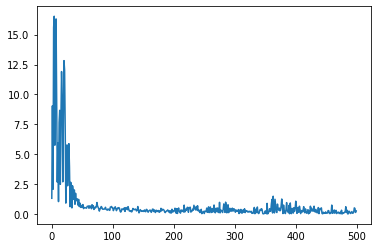

In [10]:
plt.plot(losses)